In [1]:
import numpy as np
from numpy import array, mean
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime
import time
import os
import sys
from pyspark.context import SparkContext, SparkConf
from pyspark.sql.session import SparkSession
from pyspark.sql import Row, SparkSession, Column
from pyspark.sql.functions import *
from pyspark.sql.types import * 
from pyspark.sql import functions as F

In [2]:
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [3]:
conf = SparkConf().setAppName("yelp").setMaster("local[*]")
sc = SparkContext(conf=conf)
spark = SparkSession(sc)

In [4]:
### Reading JSON files of the Yelp data
path_r = 'gs://dataproc-staging-us-west1-256569982853-ri0rhshu/notebooks/jupyter/yelp_academic_dataset_review.json'
path_u = 'gs://dataproc-staging-us-west1-256569982853-ri0rhshu/notebooks/jupyter/yelp_academic_dataset_user.json'
path_b = 'gs://dataproc-staging-us-west1-256569982853-ri0rhshu/notebooks/jupyter/yelp_academic_dataset_business.json'
path_c = 'gs://dataproc-staging-us-west1-256569982853-ri0rhshu/notebooks/jupyter/yelp_academic_dataset_checkin.json'
path_t = 'gs://dataproc-staging-us-west1-256569982853-ri0rhshu/notebooks/jupyter/yelp_academic_dataset_tip.json'

# Import JSON files into Spark DataFrames
reviews_raw = spark.read.json(path_r)
user = spark.read.json(path_u)
business_raw = spark.read.json(path_b)
checkin = spark.read.json(path_c)
tip = spark.read.json(path_t)

***Datasets description***

In [5]:
print('** Reviews **\n')

reviews_raw.printSchema()

** Reviews **

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



In [6]:
print('** Users **\n')

user.printSchema()

** Users **

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)



In [8]:
print('** Businesses **\n')

for col in business_raw.dtypes:
    print(col[0] + " , " + col[1])

** Businesses **

address , string
attributes , struct<AcceptsInsurance:string,AgesAllowed:string,Alcohol:string,Ambience:string,BYOB:string,BYOBCorkage:string,BestNights:string,BikeParking:string,BusinessAcceptsBitcoin:string,BusinessAcceptsCreditCards:string,BusinessParking:string,ByAppointmentOnly:string,Caters:string,CoatCheck:string,Corkage:string,DietaryRestrictions:string,DogsAllowed:string,DriveThru:string,GoodForDancing:string,GoodForKids:string,GoodForMeal:string,HairSpecializesIn:string,HappyHour:string,HasTV:string,Music:string,NoiseLevel:string,Open24Hours:string,OutdoorSeating:string,RestaurantsAttire:string,RestaurantsCounterService:string,RestaurantsDelivery:string,RestaurantsGoodForGroups:string,RestaurantsPriceRange2:string,RestaurantsReservations:string,RestaurantsTableService:string,RestaurantsTakeOut:string,Smoking:string,WheelchairAccessible:string,WiFi:string>
business_id , string
categories , string
city , string
hours , struct<Friday:string,Monday:string,Saturd

In [9]:
business_raw.createOrReplaceTempView("businessraw")
reviews_raw.createOrReplaceTempView("reviews")

In [10]:
print('** Checkin **\n')

checkin.printSchema()

** Checkin **

root
 |-- business_id: string (nullable = true)
 |-- date: string (nullable = true)



In [11]:
print('** Tips **\n')
print()

tip.printSchema()

** Tips **


root
 |-- business_id: string (nullable = true)
 |-- compliment_count: long (nullable = true)
 |-- date: string (nullable = true)
 |-- text: string (nullable = true)
 |-- user_id: string (nullable = true)



In [12]:
# Take a look at the first 5 rows
reviews_raw.show(10)

# How many reviews in the dataset?
# Count rows and print
print('Number of reviews:', reviews_raw.count())

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|XQfwVwDr-v0ZS3_Cb...|   0|2018-07-07 22:09:11|    0|KU_O5udG6zpxOg-Vc...|  3.0|If you decide to ...|     0|mh_-eMZ6K5RLWhZyI...|
|7ATYjTIgM3jUlt4UM...|   1|2012-01-03 15:28:18|    0|BiTunyQ73aT9WBnpR...|  5.0|I've taken a lot ...|     1|OyoGAe7OKpv6SyGZT...|
|YjUWPpI6HXG530lwP...|   0|2014-02-05 20:30:30|    0|saUsX_uimxRlCVr67...|  3.0|Family diner. Had...|     0|8g_iMtfSiwikVnbP2...|
|kxX2SOes4o-D3ZQBk...|   1|2015-01-04 00:01:03|    0|AqPFMleE6RsU23_au...|  5.0|Wow!  Yummy, diff...|     1|_7bHUi9Uuf5__HHc_...|
|e4Vwtrqf-wpJfwesg...|   1|2017-01-14 20:54:15|    0|Sx8TMOWLNuJBWer-0...|  4.0|Cute inter

In [13]:
# Reduce DataFrame to include only relevant variables
reviews = spark.sql('SELECT date, review_id, stars, text, user_id, business_id, useful FROM reviews')
business = spark.sql("SELECT business_id, name, longitude, city, categories, latitude, stars, review_count, state\
                    FROM businessraw")

In [14]:
reviews.show(5)

+-------------------+--------------------+-----+--------------------+--------------------+--------------------+------+
|               date|           review_id|stars|                text|             user_id|         business_id|useful|
+-------------------+--------------------+-----+--------------------+--------------------+--------------------+------+
|2018-07-07 22:09:11|KU_O5udG6zpxOg-Vc...|  3.0|If you decide to ...|mh_-eMZ6K5RLWhZyI...|XQfwVwDr-v0ZS3_Cb...|     0|
|2012-01-03 15:28:18|BiTunyQ73aT9WBnpR...|  5.0|I've taken a lot ...|OyoGAe7OKpv6SyGZT...|7ATYjTIgM3jUlt4UM...|     1|
|2014-02-05 20:30:30|saUsX_uimxRlCVr67...|  3.0|Family diner. Had...|8g_iMtfSiwikVnbP2...|YjUWPpI6HXG530lwP...|     0|
|2015-01-04 00:01:03|AqPFMleE6RsU23_au...|  5.0|Wow!  Yummy, diff...|_7bHUi9Uuf5__HHc_...|kxX2SOes4o-D3ZQBk...|     1|
|2017-01-14 20:54:15|Sx8TMOWLNuJBWer-0...|  4.0|Cute interior and...|bcjbaE6dDog4jkNY9...|e4Vwtrqf-wpJfwesg...|     1|
+-------------------+--------------------+-----+

In [15]:
# Take a look at the first 5 rows
reviews_raw.show(10)

# How many reviews in the dataset?
# Count rows and print
print('Number of reviews:', reviews_raw.count())

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|XQfwVwDr-v0ZS3_Cb...|   0|2018-07-07 22:09:11|    0|KU_O5udG6zpxOg-Vc...|  3.0|If you decide to ...|     0|mh_-eMZ6K5RLWhZyI...|
|7ATYjTIgM3jUlt4UM...|   1|2012-01-03 15:28:18|    0|BiTunyQ73aT9WBnpR...|  5.0|I've taken a lot ...|     1|OyoGAe7OKpv6SyGZT...|
|YjUWPpI6HXG530lwP...|   0|2014-02-05 20:30:30|    0|saUsX_uimxRlCVr67...|  3.0|Family diner. Had...|     0|8g_iMtfSiwikVnbP2...|
|kxX2SOes4o-D3ZQBk...|   1|2015-01-04 00:01:03|    0|AqPFMleE6RsU23_au...|  5.0|Wow!  Yummy, diff...|     1|_7bHUi9Uuf5__HHc_...|
|e4Vwtrqf-wpJfwesg...|   1|2017-01-14 20:54:15|    0|Sx8TMOWLNuJBWer-0...|  4.0|Cute inter

***Create SQL Views to run queries and transform data***

In [16]:
# Create temporary tables for SQL querying
reviews.createOrReplaceTempView("reviews")
user.createOrReplaceTempView("user")
business.createOrReplaceTempView("business")
tip.createOrReplaceTempView("tips")
checkin.createOrReplaceTempView("checkin")

***Get the count of Data***

In [17]:
# No. of reviews
spark.sql('SELECT COUNT(*) AS review_count FROM reviews').show()

+------------+
|review_count|
+------------+
|     6990280|
+------------+



In [18]:
# No. of businesses
spark.sql('\
    SELECT COUNT(DISTINCT business_id) AS business_count \
    FROM reviews').show()

+--------------+
|business_count|
+--------------+
|        150346|
+--------------+



In [19]:
# No. of reviewers
spark.sql('\
    SELECT COUNT(DISTINCT user_id) AS user_count \
    FROM reviews').show()

+----------+
|user_count|
+----------+
|   1987929|
+----------+



In [20]:
# No. of tips
spark.sql('\
    SELECT COUNT(business_id) AS tip_count \
    FROM tips').show()

+---------+
|tip_count|
+---------+
|   908915|
+---------+



In [21]:
# No. of visits
spark.sql('\
    SELECT COUNT(business_id) AS visit_count \
    FROM checkin').show()

+-----------+
|visit_count|
+-----------+
|     131930|
+-----------+



***Statistical values of the reviews***

In [22]:
reviews.describe('stars', 'useful').show()

+-------+------------------+------------------+
|summary|             stars|            useful|
+-------+------------------+------------------+
|  count|           6990280|           6990280|
|   mean|  3.74858374771826|1.1846089140921394|
| stddev|1.4787045052556855| 3.253766966933363|
|    min|               1.0|                -1|
|    max|               5.0|              1182|
+-------+------------------+------------------+



***Get the month, day, year and hour of the reviews***

In [23]:
from pyspark.sql.types import * 

# DEfine user-defined functions(UDF) to run SQL queries
spark.udf.register('udf_year', lambda x: int(x[:4]), IntegerType())
spark.udf.register('udf_month', lambda x: int(x[5:7]), IntegerType())
spark.udf.register('udf_day', lambda x: int(x[8:10]), IntegerType())
spark.udf.register('udf_hour', lambda x: int(x[11:13]), IntegerType())

spark.sql('\
    SELECT date, udf_year(date) AS year, udf_month(date) AS month, udf_day(date) AS day, udf_hour(date) AS hour \
    FROM reviews').show(10)

+-------------------+----+-----+---+----+
|               date|year|month|day|hour|
+-------------------+----+-----+---+----+
|2018-07-07 22:09:11|2018|    7|  7|  22|
|2012-01-03 15:28:18|2012|    1|  3|  15|
|2014-02-05 20:30:30|2014|    2|  5|  20|
|2015-01-04 00:01:03|2015|    1|  4|   0|
|2017-01-14 20:54:15|2017|    1| 14|  20|
|2015-09-23 23:10:31|2015|    9| 23|  23|
|2015-01-03 23:21:18|2015|    1|  3|  23|
|2015-08-07 02:29:16|2015|    8|  7|   2|
|2016-03-30 22:46:33|2016|    3| 30|  22|
|2016-07-25 07:31:06|2016|    7| 25|   7|
+-------------------+----+-----+---+----+
only showing top 10 rows



***Yelp reviews by year***

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# No. of reviews by year
reviewsByYear = \
    spark.sql('\
        SELECT udf_year(date) AS year, COUNT(*) AS review_count\
        FROM reviews \
        GROUP BY year')

# Convert Spark DataFrame to Pandas DataFrame
pdfYear = reviewsByYear.toPandas()
pdfYear # Take a look at the DataFrame

,year,review_count
0,2007,15363
1,2018,906362
2,2015,688415
3,2006,3853
4,2013,383950
5,2014,522275
6,2012,286570
7,2009,74387
8,2016,758882
9,2005,854


In [25]:
%matplotlib inline

# Set the DF's index to year and sort DF by year
pdfYear = pdfYear.set_index('year').sort_values(by='year')

<AxesSubplot:title={'center':'Number of Yelp reviews by year'}, xlabel='year'>

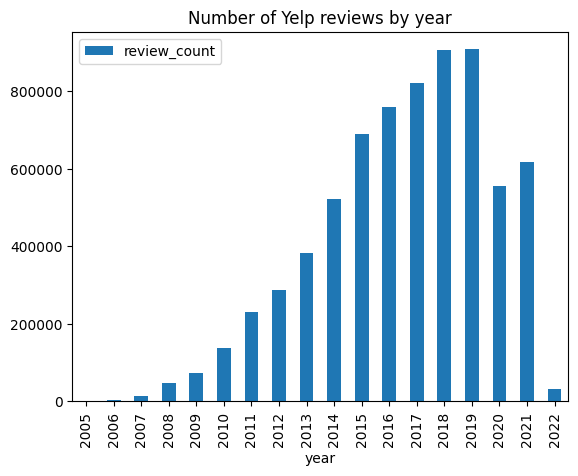

In [26]:
# Plot as bar plot
pdfYear.plot.bar(title = 'Number of Yelp reviews by year')

***Yelp reviews by month***

In [27]:
# No. of reviews by month
reviewsByMonth = \
    spark.sql('\
        SELECT udf_month(date) AS month, COUNT(*) AS review_count\
        FROM reviews \
        GROUP BY month')

# Convert PySpark DataFrame to Pandas DataFrame
pdf2 = reviewsByMonth.toPandas()

# Set the index and sort by month
pdf2 = pdf2.set_index('month').sort_values(by = 'month')

<AxesSubplot:title={'center':'Number of Yelp reviews by month (for all years)'}, xlabel='month'>

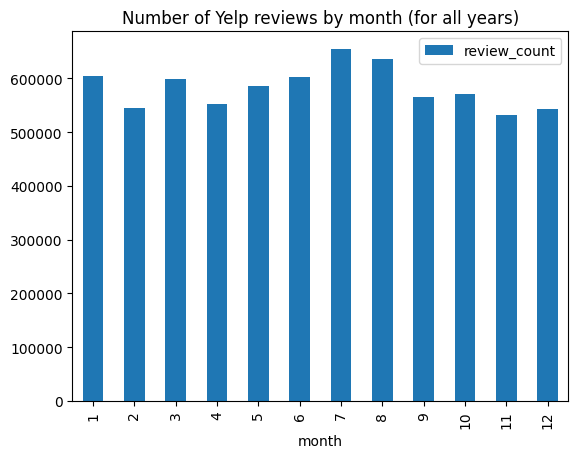

In [28]:
# Plot a bar graph
pdf2.plot.bar(title = 'Number of Yelp reviews by month (for all years)')

***Getting All the reviews with the keywork 'Terrible' in the comment***

In [29]:
reviewsTerrible = \
    spark.sql('\
        SELECT text, stars, useful \
        FROM reviews \
        WHERE text LIKE "%terrible%"')

reviewsTerrible.show(5)

+--------------------+-----+------+
|                text|stars|useful|
+--------------------+-----+------+
|The only reason I...|  4.0|     0|
|If you want to pa...|  1.0|     1|
|Service and manag...|  1.0|     0|
|Our server was aw...|  1.0|     1|
|Very unhappy, you...|  1.0|     0|
+--------------------+-----+------+
only showing top 5 rows



In [30]:
# Usefulness of review vs. time since member of yelp
usefulTime = \
    spark.sql('SELECT reviews.date, user.name, reviews.useful, user.yelping_since\
                FROM reviews JOIN user \
                ON reviews.user_id = user.user_id')

usefulTime.show(5)

+-------------------+-----+------+-------------------+
|               date| name|useful|      yelping_since|
+-------------------+-----+------+-------------------+
|2015-05-03 03:53:01| Keny|     3|2011-03-18 05:56:39|
|2015-05-21 03:18:49| Keny|     0|2011-03-18 05:56:39|
|2019-04-18 05:17:58|Rogan|     0|2013-09-11 04:19:10|
|2017-02-03 06:14:50|Rogan|     1|2013-09-11 04:19:10|
|2019-04-18 05:15:48|Rogan|     1|2013-09-11 04:19:10|
+-------------------+-----+------+-------------------+
only showing top 5 rows



In [31]:
# Create function that calculates time difference in days
daysDiff = ((F.unix_timestamp('date') - F.unix_timestamp('yelping_since')) / (60*60*24)) # Divide by number of seconds in a day

# Adjust function to round results to 4 decimal places
daysDiff = F.round(daysDiff, 4)

# Add column to our DataFrame
usefulTime = usefulTime.withColumn("yelping_duration", daysDiff)

usefulTime.show(5)

+-------------------+-----+------+-------------------+----------------+
|               date| name|useful|      yelping_since|yelping_duration|
+-------------------+-----+------+-------------------+----------------+
|2015-05-03 03:53:01| Keny|     3|2011-03-18 05:56:39|       1506.9141|
|2015-05-21 03:18:49| Keny|     0|2011-03-18 05:56:39|       1524.8904|
|2019-04-18 05:17:58|Rogan|     0|2013-09-11 04:19:10|       2045.0408|
|2017-02-03 06:14:50|Rogan|     1|2013-09-11 04:19:10|        1241.122|
|2019-04-18 05:15:48|Rogan|     1|2013-09-11 04:19:10|       2045.0393|
+-------------------+-----+------+-------------------+----------------+
only showing top 5 rows



In [32]:
# Register UDF to count number of categories
spark.udf.register('listLength', lambda x: len(x), IntegerType())

<function __main__.<lambda>(x)>

In [33]:
# Stars relative to average vs. # of categories vs. longitude
threeJoin = \
    spark.sql('\
        SELECT ROUND(reviews.stars/user.average_stars, 2) AS stars_relative, business.longitude, \
                listLength(business.categories) AS num_categories \
        FROM user \
            JOIN reviews \
                ON user.user_id = reviews.user_id \
            JOIN business \
                ON reviews.business_id = business.business_id')

threeJoin.show(5)

+--------------+---------------+--------------+
|stars_relative|      longitude|num_categories|
+--------------+---------------+--------------+
|          0.23| -90.0704155423|           130|
|          1.17| -90.0689453974|            46|
|          1.83|-119.7757894838|            51|
|          0.73|   -119.7585222|            26|
|          1.83|   -119.7173771|            76|
+--------------+---------------+--------------+
only showing top 5 rows



In [34]:
business.filter(business.city == "Austin" ).show(truncate=False)

+----------------------+----------------+-----------+------+----------------------------------------------------------------------+----------+-----+------------+-----+
|business_id           |name            |longitude  |city  |categories                                                            |latitude  |stars|review_count|state|
+----------------------+----------------+-----------+------+----------------------------------------------------------------------+----------+-----+------------+-----+
|oTRrNy5VIaTw7MKEvxZl7A|Wildlife Wonders|-82.7645055|Austin|Shopping, Outdoor Furniture Stores, Home Decor, Jewelry, Home & Garden|27.8398926|2.0  |9           |TX   |
+----------------------+----------------+-----------+------+----------------------------------------------------------------------+----------+-----+------------+-----+



In [35]:
threeJoinSD = \
    spark.sql("\
        SELECT business.name, business.city, ROUND(reviews.stars/user.average_stars, 2) AS stars_relative, \
                listLength(business.categories) AS num_categories, reviews.date \
        FROM user \
            JOIN reviews \
                ON user.user_id = reviews.user_id \
            JOIN business \
                ON reviews.business_id = business.business_id \
        WHERE business.city = 'Austin' AND reviews.date LIKE '2015-01%'")

threeJoinSD.show(5)

+----+----+--------------+--------------+----+
|name|city|stars_relative|num_categories|date|
+----+----+--------------+--------------+----+
+----+----+--------------+--------------+----+



In [36]:
# How many partitions is the DataFrame divided into?
reviews.rdd.getNumPartitions()

40

In [37]:
# Repartitioning a DataFrame to 100 partitions
reviews.repartition(100).rdd.getNumPartitions()

100

***Compare Computational Time for a simple SELECT query***

In [38]:
t1 = []
# We calculate the time for all the 
npart1 = range(60,20,-1)

for i in npart1:
    # Repartition the RDD to the ith number from 60 to 20
    reviews = reviews.repartition(i)
    
    t0 = time.time() # Start clock (call it time t0)
    
    # Run Basic Select Query
    spark.sql('SELECT date, stars, useful FROM reviews').take(1)
    
    # Measure time since t0
    dt = time.time() - t0
    
    t1 = t1 + [dt] # Add time to list for plotting purposes

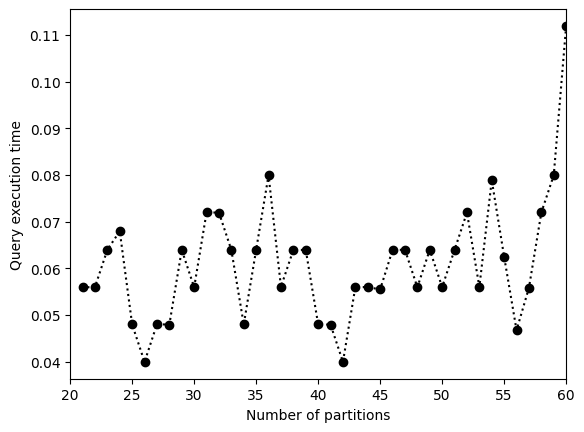

In [39]:
### Plotting the results ###

from matplotlib import pyplot as plt
%matplotlib inline

# Plot parameters
plt.plot(npart1, t1, 'ko:') # Basic parameters
plt.xlabel("Number of partitions") # x-axis label
plt.ylabel("Query execution time") # y-axis label
plt.xlim([20,60]) # x-axis limits
#plt.ylim([12,14])
plt.show() # Show

***Calculate computational speed for a query run on user defined function***

In [40]:
times2 = []
npart2 = range(60,20,-1)

for i in npart2:
    reviews = reviews.repartition(i) # Repartition the RDD
    
    t0 = time.time() # Start clock (call it time t0)
    
    # Run query
    spark.sql('\
        SELECT udf_year(date) AS year, COUNT(*) AS review_count\
        FROM reviews \
        GROUP BY year').take(1)
    
    dt = time.time() - t0 # Measure time since t0
    times2 = times2 + [dt] # Add time to list for plotting purposes

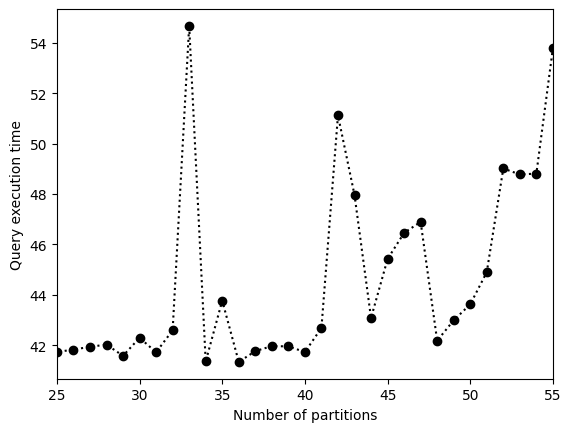

In [41]:
# Plot parameters
plt.plot(npart2, times2, 'ko:') 
plt.xlabel("Number of partitions") 
plt.ylabel("Query execution time") 
plt.xlim([25,55])
plt.show()

In [42]:
topcities = spark.sql("\
    SELECT city, count(*) as review_count, AVG(reviews.stars) as stars\
    from reviews join business\
    ON reviews.business_id=business.business_id\
    GROUP BY business.city\
    ORDER BY count(*) DESC\
    LIMIT 10")

topcities.show()

+-------------+------------+------------------+
|         city|review_count|             stars|
+-------------+------------+------------------+
| Philadelphia|      967552| 3.785672501322926|
|  New Orleans|      635364|3.9446931207937497|
|        Tampa|      454889|  3.75306503344772|
|    Nashville|      451571|3.8181659141087447|
|       Tucson|      404880|3.7008965619442797|
| Indianapolis|      361489| 3.823646086049645|
|         Reno|      351573| 3.748279873596664|
|Santa Barbara|      269630| 4.003434335941846|
|  Saint Louis|      253437| 3.814853395518413|
|        Boise|      105366| 3.789846819657195|
+-------------+------------+------------------+



In [43]:
topcities_df = topcities.toPandas()
topcities_df

,city,review_count,stars
0,Philadelphia,967552,3.785673
1,New Orleans,635364,3.944693
2,Tampa,454889,3.753065
3,Nashville,451571,3.818166
4,Tucson,404880,3.700897
5,Indianapolis,361489,3.823646
6,Reno,351573,3.748280
7,Santa Barbara,269630,4.003434
8,Saint Louis,253437,3.814853
9,Boise,105366,3.789847


In [44]:
topcities_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   city          10 non-null     object 
 1   review_count  10 non-null     int64  
 2   stars         10 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 368.0+ bytes


<AxesSubplot:xlabel='city'>

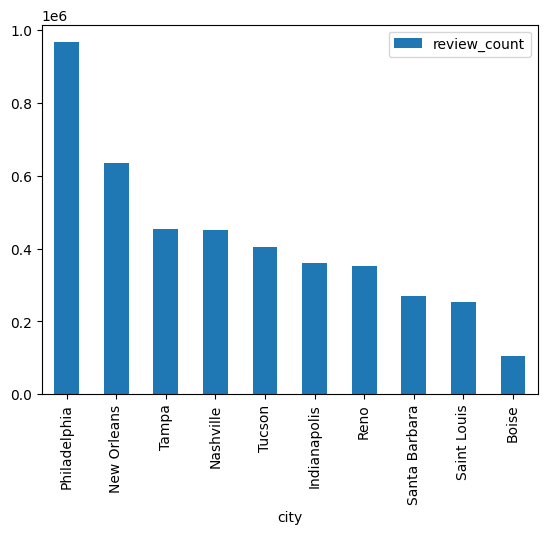

In [45]:
ax = topcities_df.plot.bar(x='city', y='review_count')
ax

In [46]:
toprate = spark.sql("\
    SELECT business.city, AVG(reviews.stars) as stars, count(*) as count\
    FROM reviews JOIN business\
    ON reviews.business_id=business.business_id\
    GROUP BY business.city\
    ORDER BY count(*) DESC\
    LIMIT 10")

toprate.show()

+-------------+------------------+------+
|         city|             stars| count|
+-------------+------------------+------+
| Philadelphia| 3.785672501322926|967552|
|  New Orleans|3.9446931207937497|635364|
|        Tampa|  3.75306503344772|454889|
|    Nashville|3.8181659141087447|451571|
|       Tucson|3.7008965619442797|404880|
| Indianapolis| 3.823646086049645|361489|
|         Reno| 3.748279873596664|351573|
|Santa Barbara| 4.003434335941846|269630|
|  Saint Louis| 3.814853395518413|253437|
|        Boise| 3.789846819657195|105366|
+-------------+------------------+------+



In [47]:
toprate.createOrReplaceTempView("toprate")

toprate2 = spark.sql("\
    SELECT *\
    FROM toprate\
    ORDER BY stars DESC")

toprate2.show()

+-------------+------------------+------+
|         city|             stars| count|
+-------------+------------------+------+
|Santa Barbara| 4.003434335941846|269630|
|  New Orleans|3.9446931207937497|635364|
| Indianapolis| 3.823646086049645|361489|
|    Nashville|3.8181659141087447|451571|
|  Saint Louis| 3.814853395518413|253437|
|        Boise| 3.789846819657195|105366|
| Philadelphia| 3.785672501322926|967552|
|        Tampa|  3.75306503344772|454889|
|         Reno| 3.748279873596664|351573|
|       Tucson|3.7008965619442797|404880|
+-------------+------------------+------+



In [48]:
toprate_df = toprate2.toPandas()
toprate_df

,city,stars,count
0,Santa Barbara,4.003434,269630
1,New Orleans,3.944693,635364
2,Indianapolis,3.823646,361489
3,Nashville,3.818166,451571
4,Saint Louis,3.814853,253437
5,Boise,3.789847,105366
6,Philadelphia,3.785673,967552
7,Tampa,3.753065,454889
8,Reno,3.748280,351573
9,Tucson,3.700897,404880


<AxesSubplot:xlabel='city'>

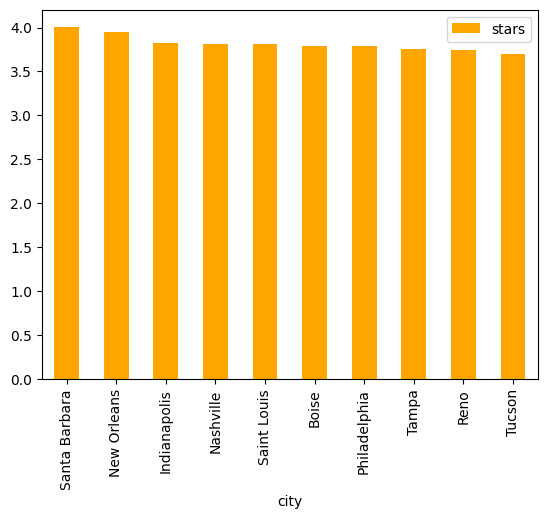

In [49]:
ax = toprate_df.plot.bar(x='city', y='stars', color='orange')
ax

In [50]:
b_catg = spark.sql("SELECT AVG(reviews.stars) as avg_stars, business.categories as category\
                                FROM reviews JOIN business\
                                ON business.business_id=reviews.business_id\
                                GROUP BY category")

b_catg.show()

+------------------+--------------------+
|         avg_stars|            category|
+------------------+--------------------+
| 3.918032786885246|Mediterranean, Fo...|
| 2.698717948717949|Auto Repair, Auto...|
|3.6494117647058824|Seafood, Restaura...|
| 4.304347826086956|Event Planning & ...|
| 4.158469945355192|Food, Specialty F...|
|2.9384615384615387|Restaurants, Comf...|
| 4.628571428571429|Parks, Active Lif...|
|3.4070796460176993|Venues & Event Sp...|
|3.6090225563909772|Restaurants, Crep...|
|3.9545454545454546|Gyms, Climbing, F...|
|               4.0|Specialty Food, F...|
| 2.911036036036036|Seafood, American...|
|            4.0625|Restaurants, Kore...|
|              4.75|Community Service...|
|              3.45|Restaurants, Sand...|
|               3.6|Dance Studios, Fi...|
| 3.254054054054054|Cupcakes, Ice Cre...|
|3.9069767441860463|Car Wash, Automot...|
|4.3428571428571425|Restaurants, Viet...|
|4.2974683544303796|Makeup Artists, H...|
+------------------+--------------

In [51]:
b_catg.createOrReplaceTempView("bcatg")

In [52]:
b_cnt = spark.sql("SELECT bcatg.category as category, COUNT(*) as count\
                    FROM bcatg JOIN business\
                    ON business.categories=bcatg.category\
                    GROUP BY category\
                    ORDER BY COUNT(*) DESC\
                    LIMIT 100")

b_cnt.show(truncate=False)

+-------------------------------+-----+
|category                       |count|
+-------------------------------+-----+
|Beauty & Spas, Nail Salons     |1012 |
|Restaurants, Pizza             |935  |
|Nail Salons, Beauty & Spas     |934  |
|Pizza, Restaurants             |823  |
|Restaurants, Mexican           |728  |
|Restaurants, Chinese           |708  |
|Mexican, Restaurants           |672  |
|Chinese, Restaurants           |651  |
|Food, Coffee & Tea             |508  |
|Beauty & Spas, Hair Salons     |493  |
|Hair Salons, Beauty & Spas     |480  |
|Coffee & Tea, Food             |473  |
|Automotive, Auto Repair        |361  |
|Auto Repair, Automotive        |351  |
|Grocery, Food                  |329  |
|Italian, Restaurants           |328  |
|Food, Grocery                  |306  |
|Veterinarians, Pets            |300  |
|Ice Cream & Frozen Yogurt, Food|298  |
|Pets, Veterinarians            |285  |
+-------------------------------+-----+
only showing top 20 rows



In [53]:
b_cnt.count()

100

In [54]:
b_cnt.createOrReplaceTempView("btop")

b_top = spark.sql("SELECT btop.category as category, AVG(reviews.stars) as avg_stars\
                    FROM btop JOIN business\
                    ON btop.category=business.categories\
                    JOIN reviews\
                    ON reviews.business_id=business.business_id\
                    GROUP BY category\
                    ORDER BY avg_stars DESC\
                    LIMIT 20")

b_top.show()

+--------------------+------------------+
|            category|         avg_stars|
+--------------------+------------------+
|Chiropractors, He...| 4.418067226890757|
|Health & Medical,...|4.3762154076290205|
|  Active Life, Parks| 4.359597924773022|
|Sewing & Alterati...| 4.296933085501859|
|Auto Repair, Auto...| 4.276751946607342|
|Local Services, S...| 4.270015698587128|
|  Parks, Active Life| 4.261885999474652|
|Barbers, Beauty &...|  4.24384093113482|
|      Bakeries, Food| 4.189776553412917|
|Beauty & Spas, Ba...| 4.184903974988834|
|Automotive, Auto ...| 4.176521550790556|
|Beauty & Spas, Ha...| 4.107516339869281|
|Food, Ice Cream &...| 4.107062665850173|
|      Food, Bakeries| 4.052176063303659|
| Restaurants, Indian| 4.018078256562655|
|Hair Salons, Beau...| 4.011811470755252|
| Indian, Restaurants| 4.010311540149188|
|Home Services, He...| 4.005027652086476|
|   Restaurants, Thai|3.9846290933392736|
|   Thai, Restaurants| 3.975803623611923|
+--------------------+------------

In [55]:
df_btop = b_top.toPandas()
df_btop

,category,avg_stars
0,"Chiropractors, Health & Medical",4.418067
1,"Health & Medical, Chiropractors",4.376215
2,"Active Life, Parks",4.359598
3,"Sewing & Alterations, Local Services",4.296933
4,"Auto Repair, Automotive",4.276752
5,"Local Services, Sewing & Alterations",4.270016
6,"Parks, Active Life",4.261886
7,"Barbers, Beauty & Spas",4.243841
8,"Bakeries, Food",4.189777
9,"Beauty & Spas, Barbers",4.184904


<AxesSubplot:xlabel='category'>

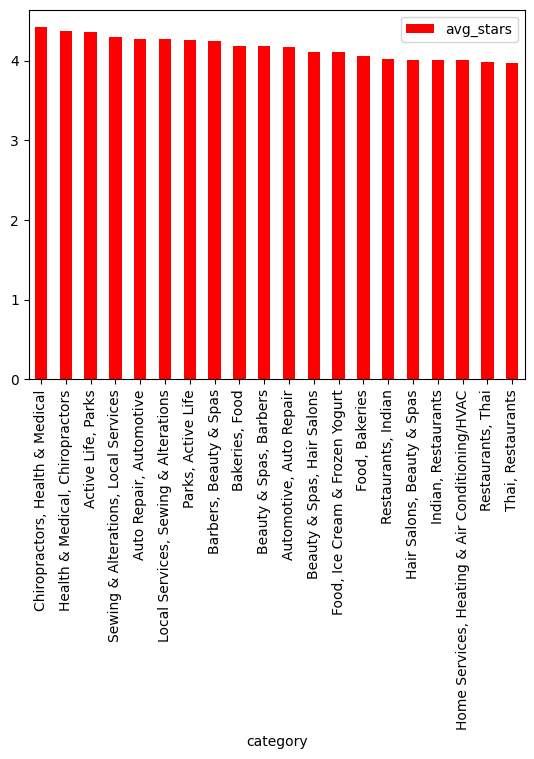

In [56]:
ax = df_btop.plot.bar(x='category', y='avg_stars', color='red')
ax

In [57]:
df_bcnt = b_cnt.toPandas()
df_bcnt

,category,count
0,"Beauty & Spas, Nail Salons",1012
1,"Restaurants, Pizza",935
2,"Nail Salons, Beauty & Spas",934
3,"Pizza, Restaurants",823
4,"Restaurants, Mexican",728
...,...,...
95,"Restaurants, Breakfast & Brunch",104
96,"Home Services, Movers",103
97,"Local Services, Sewing & Alterations",103
98,"Italian, Pizza, Restaurants",103


<AxesSubplot:xlabel='category'>

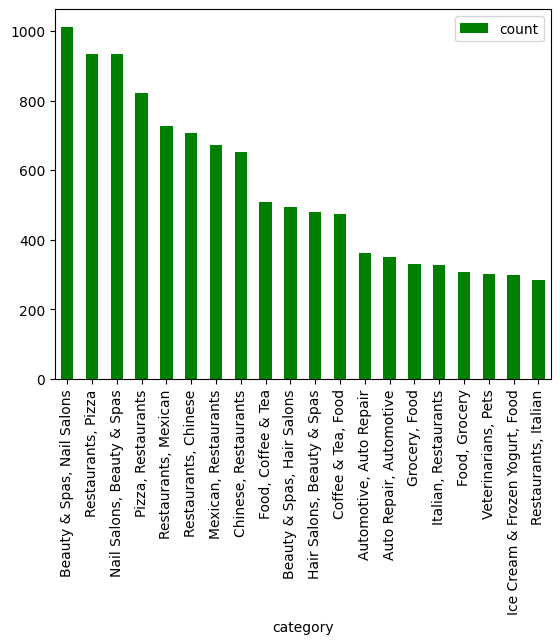

In [58]:
ax = df_bcnt[:20].plot.bar(x='category', y='count', color='green')
ax

In [59]:
b_usfl = spark.sql("SELECT AVG(reviews.useful) as usefulness, business.categories as category\
                    FROM reviews JOIN business\
                    ON reviews.business_id=business.business_id\
                    GROUP BY category\
                    ORDER BY usefulness DESC")

b_usfl.show()

+------------------+--------------------+
|        usefulness|            category|
+------------------+--------------------+
|             87.75|Data Recovery, IT...|
| 80.75590551181102|Real Estate, Mort...|
| 75.72340425531915|Hats, Accessories...|
| 51.23809523809524|Transportation, L...|
| 50.09803921568628|Health & Medical,...|
| 48.84722222222222|Accessories, Fash...|
|              35.2|Event Photography...|
|30.555555555555557|Cryotherapy, Reha...|
|30.357142857142858|Local Services, C...|
|             29.25|Active Life, Spec...|
|              29.0|Automotive, Auto ...|
| 27.58974358974359|Pet Training, Pet...|
|            26.375|Home & Garden, Ou...|
|24.761194029850746|Movers, American ...|
|              24.0|Retirement Homes,...|
|              23.8|Religious Organiz...|
|              23.6|Cards & Stationer...|
|22.533333333333335|Event Planning & ...|
|22.505494505494507|Sandwiches, Burge...|
|22.428571428571427|Shopping, Pharmac...|
+------------------+--------------

In [60]:
v_cnts = spark.sql("SELECT COUNT(checkin.date) visits, business.categories as category\
                    FROM checkin JOIN business\
                    ON checkin.business_id=business.business_id\
                    GROUP BY category\
                    ORDER BY visits DESC")

v_cnts.show()

+------+--------------------+
|visits|            category|
+------+--------------------+
|   940|Beauty & Spas, Na...|
|   902|  Restaurants, Pizza|
|   882|Nail Salons, Beau...|
|   785|  Pizza, Restaurants|
|   717|Restaurants, Mexican|
|   698|Restaurants, Chinese|
|   658|Mexican, Restaurants|
|   642|Chinese, Restaurants|
|   501|  Food, Coffee & Tea|
|   471|  Coffee & Tea, Food|
|   440|Beauty & Spas, Ha...|
|   437|Hair Salons, Beau...|
|   327|       Grocery, Food|
|   318|Italian, Restaurants|
|   300|       Food, Grocery|
|   294|Ice Cream & Froze...|
|   278|Restaurants, Italian|
|   275|Food, Ice Cream &...|
|   273|Hotels & Travel, ...|
|   272|Hotels, Hotels & ...|
+------+--------------------+
only showing top 20 rows



In [61]:
b_usfl.createOrReplaceTempView("busfl")
v_cnts.createOrReplaceTempView("vcnts")

usfl_v_cnts = spark.sql("SELECT busfl.usefulness, vcnts.visits\
                        FROM busfl JOIN vcnts\
                        ON busfl.category=vcnts.category\
                        WHERE vcnts.visits>50 AND vcnts.visits<500\
                        ORDER BY vcnts.visits DESC, busfl.usefulness DESC\
                        LIMIT 500")

usfl_v_cnts.show()

+------------------+------+
|        usefulness|visits|
+------------------+------+
|1.0443493921656912|   471|
| 1.567755991285403|   440|
|1.7543441226575809|   437|
|1.4437427289346851|   327|
|1.0649473964070038|   318|
| 1.557079081632653|   300|
|1.0083617218953236|   294|
|1.0557839107457427|   278|
| 1.126658501735048|   275|
|1.0044705224923163|   273|
|0.9874842340157175|   272|
| 1.015712900096993|   266|
|1.0310249731882948|   265|
|1.0462324788972353|   263|
|2.1224944320712695|   261|
|0.9879853902345251|   261|
|1.4578420467185762|   252|
|1.3504440112627247|   251|
|0.9761054041983028|   251|
|1.0552228200182723|   243|
+------------------+------+
only showing top 20 rows



In [62]:
df_usfl_cnts = usfl_v_cnts.toPandas()
df_usfl_cnts

,usefulness,visits
0,1.044349,471
1,1.567756,440
2,1.754344,437
3,1.443743,327
4,1.064947,318
...,...,...
160,1.790233,51
161,1.379195,51
162,1.358180,51
163,0.916667,51


<AxesSubplot:xlabel='visits', ylabel='usefulness'>

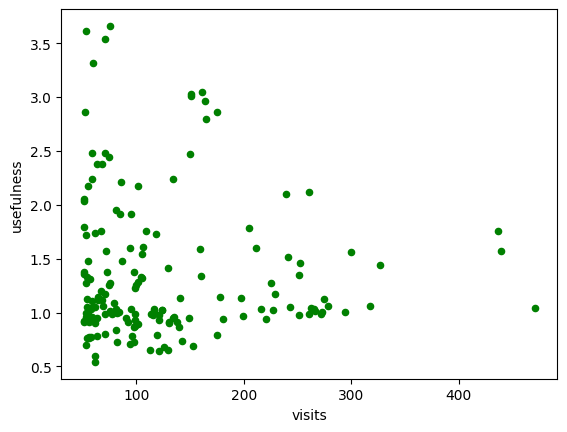

In [63]:
ax = df_usfl_cnts.plot.scatter(x='visits', y='usefulness',c='green')
ax

In [64]:
bc_usfl = spark.sql("SELECT AVG(reviews.useful) as avg_useful, business.categories as category\
                    FROM reviews JOIN business\
                    ON reviews.business_id=business.business_id\
                    GROUP BY category\
                    ORDER BY avg_useful DESC\
                    LIMIT 25")

bc_usfl.show()

+------------------+--------------------+
|        avg_useful|            category|
+------------------+--------------------+
|             87.75|Data Recovery, IT...|
| 80.75590551181102|Real Estate, Mort...|
| 75.72340425531915|Hats, Accessories...|
| 51.23809523809524|Transportation, L...|
| 50.09803921568628|Health & Medical,...|
| 48.84722222222222|Accessories, Fash...|
|              35.2|Event Photography...|
|30.555555555555557|Cryotherapy, Reha...|
|30.357142857142858|Local Services, C...|
|             29.25|Active Life, Spec...|
|              29.0|Automotive, Auto ...|
| 27.58974358974359|Pet Training, Pet...|
|            26.375|Home & Garden, Ou...|
|24.761194029850746|Movers, American ...|
|              24.0|Retirement Homes,...|
|              23.8|Religious Organiz...|
|              23.6|Cards & Stationer...|
|22.533333333333335|Event Planning & ...|
|22.505494505494507|Sandwiches, Burge...|
|22.428571428571427|Shopping, Pharmac...|
+------------------+--------------

In [65]:
df_bcusfl = bc_usfl.toPandas()
df_bcusfl

,avg_useful,category
0,87.750000,"Data Recovery, IT Services & Computer Repair, ..."
1,80.755906,"Real Estate, Mortgage Brokers, Home Services"
2,75.723404,"Hats, Accessories, Fashion, Shopping"
3,51.238095,"Transportation, Limos, Wine Tours, Tours, Airp..."
4,50.098039,"Health & Medical, Dentists, Cosmetic Dentists,..."
5,48.847222,"Accessories, Fashion, Shopping, Jewelry, Women..."
6,35.200000,"Event Photography, Photographers, Session Phot..."
7,30.555556,"Cryotherapy, Rehabilitation Center, Acupunctur..."
8,30.357143,"Local Services, Couriers & Delivery Services, ..."
9,29.250000,"Active Life, Specialty Schools, Firearm Traini..."


<AxesSubplot:xlabel='category'>

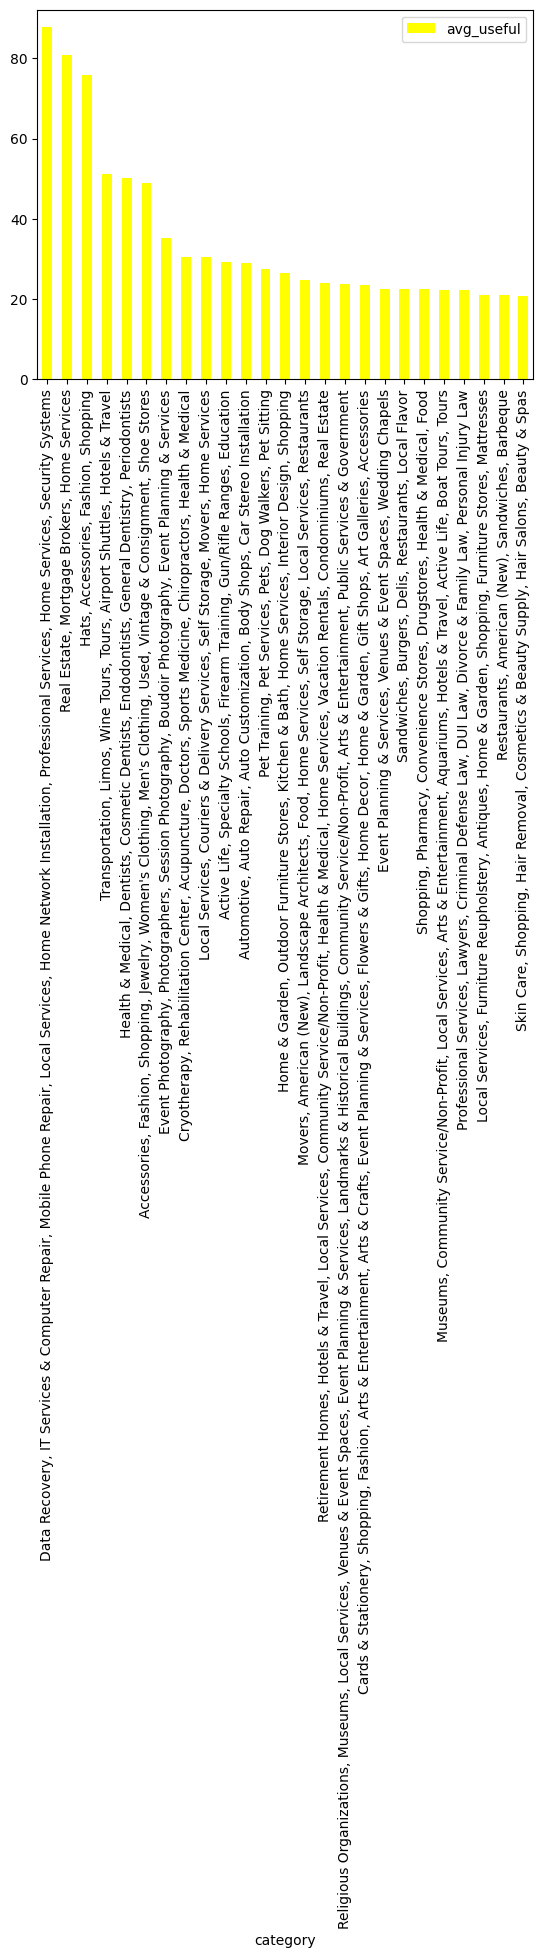

In [66]:
ax = df_bcusfl.plot.bar(x='category', y='avg_useful', color='yellow')
ax

In [67]:
bc_visits = spark.sql("SELECT COUNT(checkin.date) as visits, business.categories as category\
                        FROM checkin JOIN business\
                        ON checkin.business_id=business.business_id\
                        GROUP BY category\
                        ORDER BY visits DESC\
                        LIMIT 25")

bc_visits.show()

+------+--------------------+
|visits|            category|
+------+--------------------+
|   940|Beauty & Spas, Na...|
|   902|  Restaurants, Pizza|
|   882|Nail Salons, Beau...|
|   785|  Pizza, Restaurants|
|   717|Restaurants, Mexican|
|   698|Restaurants, Chinese|
|   658|Mexican, Restaurants|
|   642|Chinese, Restaurants|
|   501|  Food, Coffee & Tea|
|   471|  Coffee & Tea, Food|
|   440|Beauty & Spas, Ha...|
|   437|Hair Salons, Beau...|
|   327|       Grocery, Food|
|   318|Italian, Restaurants|
|   300|       Food, Grocery|
|   294|Ice Cream & Froze...|
|   278|Restaurants, Italian|
|   275|Food, Ice Cream &...|
|   273|Hotels & Travel, ...|
|   272|Hotels, Hotels & ...|
+------+--------------------+
only showing top 20 rows



In [68]:
df_bcvisits = bc_visits.toPandas()
df_bcvisits

,visits,category
0,940,"Beauty & Spas, Nail Salons"
1,902,"Restaurants, Pizza"
2,882,"Nail Salons, Beauty & Spas"
3,785,"Pizza, Restaurants"
4,717,"Restaurants, Mexican"
5,698,"Restaurants, Chinese"
6,658,"Mexican, Restaurants"
7,642,"Chinese, Restaurants"
8,501,"Food, Coffee & Tea"
9,471,"Coffee & Tea, Food"


<AxesSubplot:xlabel='category'>

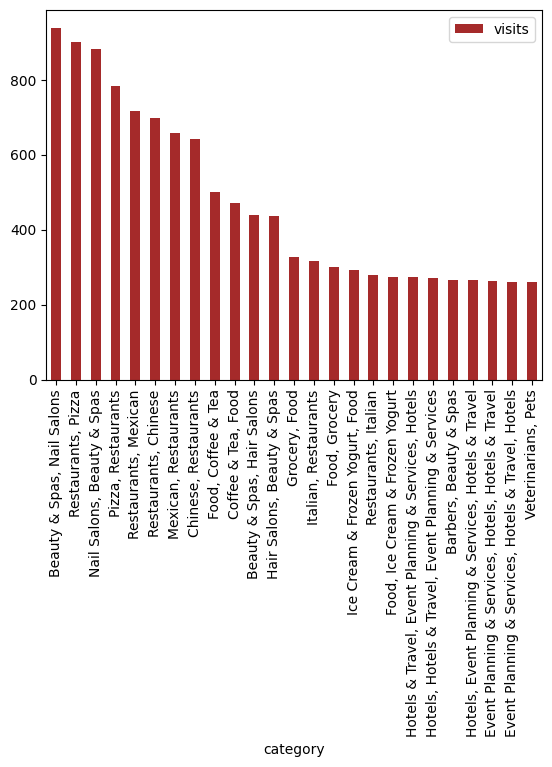

In [69]:
ax = df_bcvisits.plot.bar(x='category', y='visits', color='brown')
ax

In [70]:
u_usfl = spark.sql("SELECT COUNT(reviews.review_id) as count_of_reviews, AVG(reviews.useful) as avg_useful\
                    FROM reviews JOIN user\
                    ON reviews.user_id=user.user_id\
                    GROUP BY reviews.user_id\
                    ORDER BY count_of_reviews DESC\
                    LIMIT 1000")

u_usfl.createOrReplaceTempView("uusfl")

u_usfl = spark.sql("SELECT * FROM uusfl WHERE count_of_reviews >10 AND count_of_reviews<500")

u_usfl.show()

+----------------+------------------+
|count_of_reviews|        avg_useful|
+----------------+------------------+
|             499|  7.24248496993988|
|             498|1.7690763052208835|
|             498|1.0080321285140563|
|             498|1.9236947791164658|
|             492|3.3658536585365852|
|             490|1.6714285714285715|
|             490|4.6204081632653065|
|             484| 2.946280991735537|
|             483|2.7784679089026914|
|             483|3.6438923395445135|
|             482|2.1016597510373445|
|             480|           2.15625|
|             480|             4.625|
|             479|2.3507306889352817|
|             479| 5.106471816283925|
|             478| 2.481171548117155|
|             477|3.4318658280922434|
|             476|1.8823529411764706|
|             475|3.5389473684210526|
|             475| 6.383157894736842|
+----------------+------------------+
only showing top 20 rows



In [71]:
df_uusfl = u_usfl.toPandas()
df_uusfl

,count_of_reviews,avg_useful
0,499,7.242485
1,498,1.769076
2,498,1.008032
3,498,1.923695
4,492,3.365854
...,...,...
850,223,2.780269
851,222,3.779279
852,222,0.211712
853,222,3.941441


<AxesSubplot:xlabel='count_of_reviews', ylabel='avg_useful'>

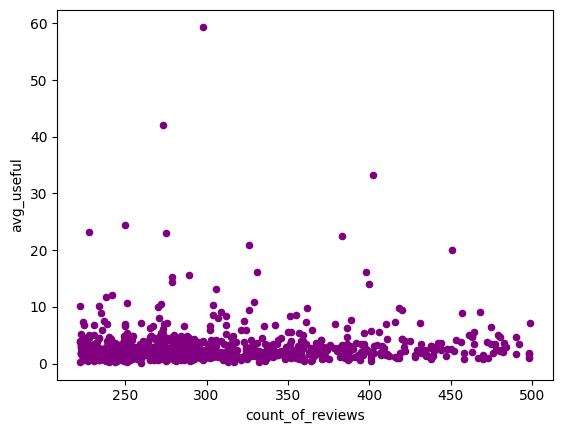

In [72]:
ax = df_uusfl.plot.scatter(x='count_of_reviews', y='avg_useful', c='purple')
ax